Exploring torch for the sfNorm model

In [19]:
import torch
import torch.nn as nn
from torch.utils import data as torchdata

import numpy as np
import time

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf as pltSave
import seaborn as sns

import sys
sys.path.insert(0, '../')
import helper_fcns as hf
import helper_fcns_sfBB as hfsf
import model_responses_pytorch as mrpt

import pdb


In [20]:
import autoreload as ar
ar.reload(mrpt);

In [21]:
### Helper
def _cast_as_tensor(x, device_in="cpu"):
    # needs to be float32 to work with the Hessian calculations
    return torch.tensor(x, dtype=torch.float32, device=device_in)

def _cast_as_param(x, device_in="cpu", requires_grad=True):
    # from Billy
    return torch.nn.Parameter(_cast_as_tensor(x, device_in=device_in), requires_grad=requires_grad)


In [22]:
### DATALOADER

class dataWrapper(torchdata.Dataset):   
    def __init__(self, trInf, resp, device='cpu'):
        super().__init__();

        self.trInf = trInf;
#         self.sfs = sfs;
        self.resp = resp;
        self.device = device;
        
    def get_single_item(self, idx):
#         feature = _cast_as_tensor(self.sfs[idx])
#         target = _cast_as_tensor(self.resp[idx])
        feature = dict();
        feature['ori'] = _cast_as_tensor(self.trInf['ori'][idx, :])
        feature['tf'] = _cast_as_tensor(self.trInf['tf'][idx, :])
        feature['sf'] = _cast_as_tensor(self.trInf['sf'][idx, :])
        feature['con'] = _cast_as_tensor(self.trInf['con'][idx, :])
        feature['ph'] = _cast_as_tensor(self.trInf['ph'][idx, :])
        feature['num'] = trInf['ori'].shape[0] # num is the # of trials included here...
        
        target = _cast_as_tensor(self.resp[idx]);
        
        return (feature, target.to(self.device));

    def __getitem__(self, idx):
        return self.get_single_item(idx)

    def __len__(self):
        return len(self.resp)

In [23]:
### The model
# class sfNormMod(torch.nn.Module):

#     def __init__(self, modParams, excType=2, normType=1, lossType=1, lgnFrontEnd=0):
#         super().__init__();
        
#         self.excType = excType
#         self.normType = normType;
#         self.lossType = lossType;
#         self.lgnFrontEnd = lgnFrontEnd;

#         # testing flex gauss
#         self.prefSf = _cast_as_param(modParams[0]);
#         if excType == 2:
#             self.sigLow = _cast_as_param(modParams[1]);
#             highInd = -1-np.sign(lgnFrontEnd);
#             self.sigHigh = _cast_as_param(modParams[highInd]);
        
#         # testing DiffOfGauss
# #         self.prefSf = _cast_as_param(modParams[0]);
# #         self.gain = _cast_as_param(modParams[1]);
# #         self.gainS = _cast_as_param(modParams[2]);
# #         self.sfS = _cast_as_param(modParams[3]);

#         # testing DoGsach
# #         self.gain_c = _cast_as_param(modParams[0]);
# #         self.gain_s = _cast_as_param(modParams[1]);
# #         self.r_c = _cast_as_param(modParams[2]);
# #         self.r_s = _cast_as_param(modParams[3]);

#     def forward(self, stimSf):

# #         s = mrpt.DoGsach(self.gain_c, self.r_c, self.gain_s, self.r_s, stimSf);
# #         s = mrpt.DiffOfGauss(self.gain, self.prefSf, self.gainS, self.sfS, stimSf);
#         s = mrpt.flexible_Gauss([_cast_as_tensor(0), _cast_as_tensor(1), self.prefSf, self.sigLow, self.sigHigh], stimSf, minThresh=0)

#         return torch.clamp(s, min=1e-4);
    
# def loss_sfNormMod(respModel, respData, lossType=1):

#     if lossType == 1:
#         lsq = torch.pow(torch.sign(respModel)*torch.sqrt(torch.abs(respModel)) - torch.sign(respData)*torch.sqrt(torch.abs(respData)), 2);
# #         eps=1e-7
# #         lsq = torch.log10(eps+ torch.pow(torch.sign(respModel)*torch.sqrt(torch.abs(respModel)) - torch.sign(respData)*torch.sqrt(torch.abs(respData)), 2));

#         NLL = torch.mean(lsq);

#     return NLL;

In [24]:
import autoreload as ar
ar.reload(mrpt);
ar.reload(hf);

In [35]:
# Set-up the model, data, parameters, etc
cellNum = 1;
loc_str = ''
loc = '../V1_BB/structures/'

if 'BB' in loc:

    dl = hf.np_smart_load('%sdataList.npy' % loc) # for V1_BB/
    cell = hf.np_smart_load('%s%s_sfBB.npy' % (loc, dl['unitName'][cellNum-1]));
    coreExp = cell['sfBB_core'];
    trialInf = coreExp['trial'];
    expInd = -1; # expInd doesn't apply here...

else:
    
    dl = hf.np_smart_load('%sdataList_glx_200507.npy' % loc) # for V1/
    cell = hf.np_smart_load('%s%s_sfm.npy' % (loc, dl['unitName'][cellNum-1]));
    trialInf = cell['sfm']['exp']['trial'];
    expInd = hf.get_exp_ind(loc, dl['unitName'][cellNum-1])[0];

excType=2
normType=1
lossType=1
lgnFrontEnd=0

if excType == 1:
    fL_name = 'fitList%s_200417' % (loc_str);
elif excType == 2:
    fL_name = 'fitList%s_200507' % (loc_str);
    
if lgnFrontEnd == 1:
    fL_name = '%s_LGN' % fL_name # implicit "a" at the end of LGN... 
elif lgnFrontEnd == 2:
    fL_name = '%s_LGNb' % fL_name

if 'BB' in loc:
    initFromCurr = 0
    # --- first, estimate prefSf, normConst if possible (TODO)                                                                                                                         
    prefSfEst = 1;
    normConst = -2;
    # --- then, set up each parameter                                                                                                                                                  
    pref_sf = float(prefSfEst) if initFromCurr==0 else curr_params[0];
    if excType == 1:
        dOrdSp = np.random.uniform(1, 3) if initFromCurr==0 else curr_params[1];
    elif excType == 2:
        sigLow = np.random.uniform(1, 4) if initFromCurr==0 else curr_params[1];
        sigHigh = np.random.uniform(0.1, 2) if initFromCurr==0 else curr_params[-1-numpy.sign(lgnFrontEnd)];                                                                                                        
    normConst = normConst if initFromCurr==0 else curr_params[2];
    respExp = np.random.uniform(1.5, 2.5) if initFromCurr==0 else curr_params[3];
    # easier to start with a small scalar and work up, rather than work down                                                                                                           
    respScalar = np.random.uniform(0.05, 0.25) if initFromCurr==0 else curr_params[4];
    noiseEarly = np.random.uniform(0.001, 0.01) if initFromCurr==0 else curr_params[5];
    noiseLate = np.random.uniform(0.1, 1) if initFromCurr==0 else curr_params[6];
    varGain = np.random.uniform(0.1, 1) if initFromCurr==0 else curr_params[7];
    if lgnFrontEnd > 0:
        # Now, the LGN weighting                                                                                                                                                         
        mWeight = np.random.uniform(0.25, 0.75) if initFromCurr==0 else curr_params[-1];
    else:
        mWeight = np.nan

    # --- finally, actually create the parameter list                                                                                                                                  
    if normType == 1:
        inhAsym = 0
        if excType == 1:
            param_list = (pref_sf, dOrdSp, normConst, respExp, respScalar, noiseEarly, noiseLate, varGain, inhAsym, mWeight);
        elif excType == 2:
            param_list = (pref_sf, sigLow, normConst, respExp, respScalar, noiseEarly, noiseLate, varGain, inhAsym, sigHigh, mWeight);
    elif normType == 2:
        normMean = np.log10(prefSfEst)
        normStd = 1.5;
        if excType == 1:
            param_list = (pref_sf, dOrdSp, normConst, respExp, respScalar, noiseEarly, noiseLate, varGain, normMean, normStd, mWeight);
        elif excType == 2:
            param_list = (pref_sf, sigLow, normConst, respExp, respScalar, noiseEarly, noiseLate, varGain, normMean, normStd, sigHigh, mWeight);
    fitParams = param_list;
else:
    fitListName = hf.fitList_name(base=fL_name, fitType=normType, lossType=lossType);
    fL = hf.np_smart_load('%s%s' % (loc,fitListName))
    fitParams = fL[cellNum-1]['params'];


#### Interlude: trying to fit multiple cells jointly, with matrix ops rather than doing each cell separately in loops (or parallel processing)

In [718]:
### Trying to create joint trInf structures...

jointTrInf = dict();
# stack the data with cells as the last dim...
for k in trInf.keys():
    curr = np.atleast_2d(trInf[k]);
    shp_base = curr.shape;
    newone = np.empty((shp_base[0], shp_base[1], 2));

    newone[:,:,0] = trInf[k]
    newone[:,:,1] = trInf[k]
    
    jointTrInf[k] = newone

In [717]:
import model_responses as mr

In [679]:
import autoreload as ar
ar.reload(mr);

# just for passing in to SFMSimpleResp_matMul
channel = dict();
pref = dict();
dord = dict();
pref['sf'] = 1;
dord['ti'] = 0.1;
dord['sp'] = 1;
channel['sigLow'] = 1;
channel['sigHigh'] = 1;
channel['mWeight'] = 0.5;
channel['pref'] = pref;
channel['dord'] = dord;

#### Back to where we were

In [36]:
# modTest = mrpt.sfNormMod(fitParams, expInd, excType=excType, normType=normType, lossType=lossType, lgnFrontEnd=lgnFrontEnd)
fp = np.copy(fitParams);
# fp[0] = fitParams[0]*0.5
# fp[1] = fitParams[1]*1.5
# fp[2] = fitParams[2]*0.25
modTrain = mrpt.sfNormMod(fp, expInd, excType=excType, normType=normType, lossType=lossType, lgnFrontEnd=lgnFrontEnd)


In [42]:
ar.reload(hf);
ar.reload(hfsf);
ar.reload(mrpt);

In [43]:
trInf, resp = mrpt.process_data(coreExp, expInd=-1, respMeasure=0)

In [38]:
# first, clean the data of NaN/blank trials...
# -- well, this is actually where NOT NaN, but ok
whereNotBlank = np.where(np.logical_or(trialInf['maskOn'], trialInf['baseOn']))[0]
# whereNan = np.where(~np.isnan(np.sum(trialInf['ori'], 0)))[0];
whereNan = whereNotBlank;
trInf = dict();
trInf['num'] = whereNan;
trInf['ori'] = np.transpose(np.vstack(trialInf['ori']), (1,0))[whereNan, :]
trInf['tf'] = np.transpose(np.vstack(trialInf['tf']), (1,0))[whereNan, :]
trInf['ph'] = np.transpose(np.vstack(trialInf['ph']), (1,0))[whereNan, :]
trInf['sf'] = np.transpose(np.vstack(trialInf['sf']), (1,0))[whereNan, :]
trInf['con'] = np.transpose(np.vstack(trialInf['con']), (1,0))[whereNan, :]
trInf['spikeCount'] = coreExp['spikeCounts'][whereNan];
trInf['spikeCount'] = coreExp['spikeCounts'][whereNan];
# trInf['spikeCount'] = trialInf['spikeCount'][whereNan];
# trInf['spikeCount'] = trialInf['spikeCount'][whereNan];

In [840]:
# output = modTest.forward(trInf);
# consider adding noise...
init_fit = modTrain.forward(trInf)

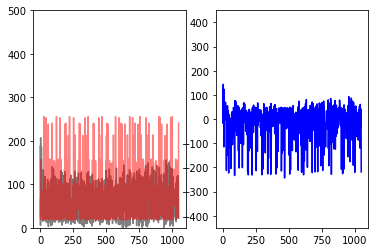

In [843]:
plt.subplot(1,2,1)
init_as_np = init_fit[:,].detach().numpy()
plt.plot(trInf['spikeCount'], 'k', alpha=0.5)
# plt.plot(output[:,].detach(), 'k')
plt.plot(init_as_np, 'r', alpha=0.5)
plt.ylim([-0.1, 500]);

plt.subplot(1,2,2)
plt.plot(trInf['spikeCount'] - init_as_np, 'b')
plt.ylim([-450, 450]);

In [ ]:
### Now, the optimization
# - what to specify...
model = modTrain; # what's our model?

learning_rate = 0.01;
training_parameters = [p for p in model.parameters() if p.requires_grad]
max_epochs = 500;

# --- data wrapping
dw = dataWrapper(trInf, trInf['spikeCount'])
batch_size = 50;
dataloader = torchdata.DataLoader(dw, batch_size)

# - then set it up
# optimizer = torch.optim.SGD(training_parameters, lr=learning_rate)
optimizer = torch.optim.Adam(training_parameters, amsgrad=True, lr=learning_rate, )
# - then data
# - predefine some arrays for tracking loss
loss_history = []
start_time = time.time()
time_history = []
model_history = []
hessian_history = []

first_pred = model(trInf);
# print(first_pred)

for t in range(max_epochs):
    optimizer.zero_grad()

    loss_history.append([])
    time_history.append([])

    for bb, (feature, target) in enumerate(dataloader):
        predictions = model(feature)
        loss_curr = mrpt.loss_sfNormMod(predictions, target, model.lossType)

        if np.mod(t,100)==0 and bb==0:
            print('\n****** STEP %d *********' % t)
            prms = model.named_parameters()
            [print(x, '\n') for x in prms];
            print(loss_curr.item())
            print(loss_curr.grad)

        loss_history[t].append(loss_curr.item())
        time_history[t].append(time.time() - start_time)
        if np.isnan(loss_curr.item()) or np.isinf(loss_curr.item()):
            # we raise an exception here and then try again.
            raise Exception("Loss is nan or inf on epoch %s, batch %s!" % (t, 0))

#         loss_curr.backward()
        loss_curr.backward(retain_graph=True)
        optimizer.step()

    model.eval()
    model.train()


../model_responses_pytorch.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x, dtype=dtype, device=device)



****** STEP 0 *********
('mWeight', Parameter containing:
tensor(0.4016, requires_grad=True)) 

('prefSf', Parameter containing:
tensor(2.3834, requires_grad=True)) 

('sigLow', Parameter containing:
tensor(1.3519, requires_grad=True)) 

('sigHigh', Parameter containing:
tensor(0.4016, requires_grad=True)) 

('respExp', Parameter containing:
tensor(1.1259, requires_grad=True)) 

('scale', Parameter containing:
tensor(822.3488, requires_grad=True)) 

('noiseEarly', Parameter containing:
tensor(0., requires_grad=True)) 

('noiseLate', Parameter containing:
tensor(17.6783, requires_grad=True)) 

('varGain', Parameter containing:
tensor(0.1877, requires_grad=True)) 

11.994438171386719
None

****** STEP 100 *********
('mWeight', Parameter containing:
tensor(0.4016, requires_grad=True)) 

('prefSf', Parameter containing:
tensor(0.8140, requires_grad=True)) 

('sigLow', Parameter containing:
tensor(1.7078, requires_grad=True)) 

('sigHigh', Parameter containing:
tensor(0.0097, requires_grad

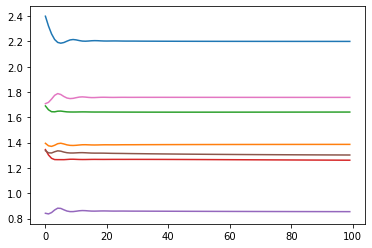

In [828]:
plt.plot(loss_history);

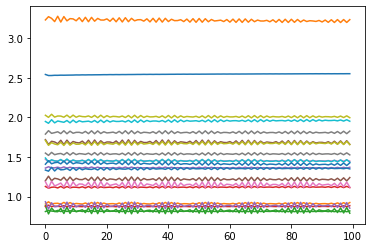

In [834]:
plt.plot(loss_history);

In [832]:
# modFin = modTrain

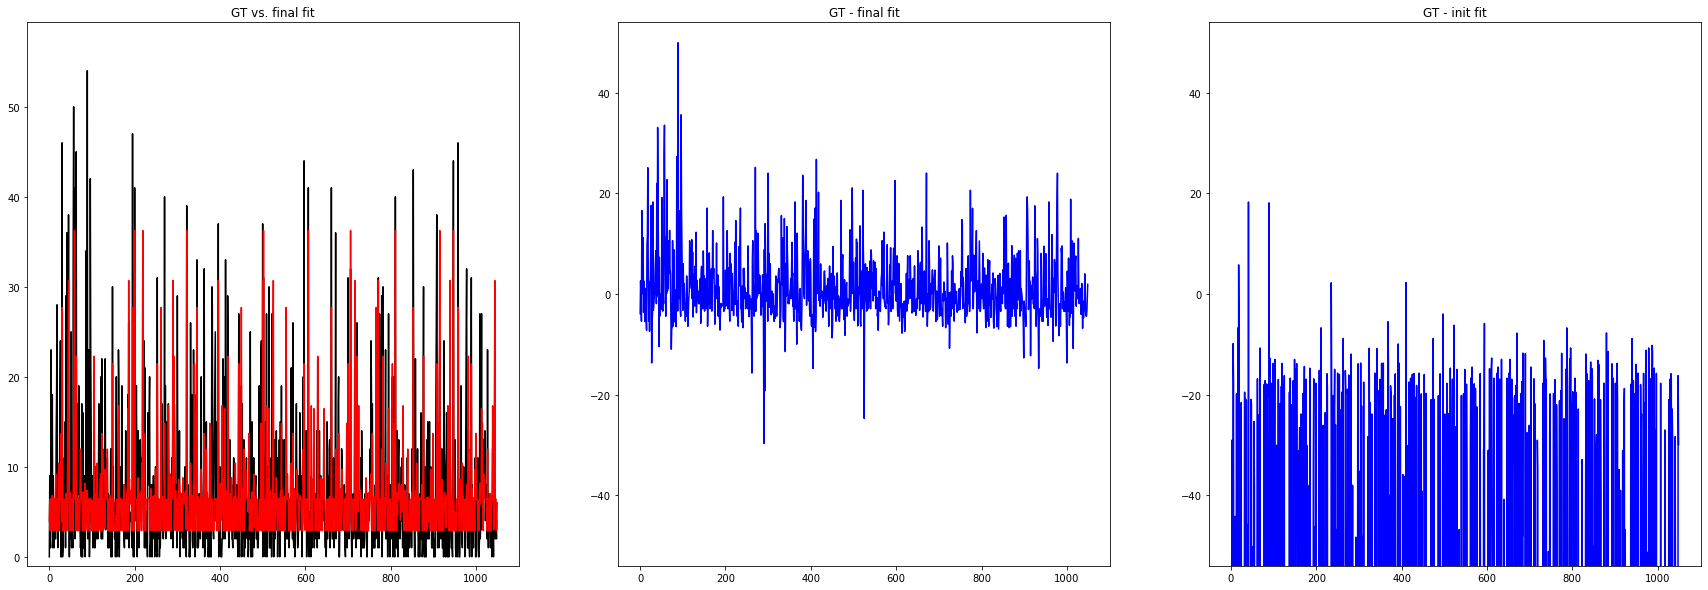

In [833]:
final_fit = modTrain.forward(trInf)
final_fit = final_fit.detach().numpy();

f, ax = plt.subplots(figsize=(30, 10))

max_resp = np.maximum(np.max(trInf['spikeCount']), np.max(final_fit));

plt.subplot(1,3,1)
plt.plot(trInf['spikeCount'], 'k')
plt.plot(final_fit, 'r')
plt.ylim([-1, 1.1*max_resp]);
plt.title('GT vs. final fit');

plt.subplot(1,3,2)
plt.plot(trInf['spikeCount'] - final_fit, 'b')
plt.ylim([-max_resp, max_resp]);
plt.title('GT - final fit');

plt.subplot(1,3,3)
plt.plot(trInf['spikeCount'] - init_as_np, 'b')
plt.ylim([-max_resp, max_resp]);
plt.title('GT - init fit');


### original/dumb

In [ ]:
# testing flexible_Gauss
# prefSf = 1;
# sigLow = 0.9;
# sigHigh = 0.4;
# testMod = sfNormMod(modParams=[prefSf, sigLow, sigHigh])
# trainMod = sfNormMod(modParams=[prefSf*3, sigLow, sigLow])

# testing DiffOfGauss
# prefSf, gain, gainS, sfS = 3, 1, 0.3, 0.3;
# testMod = sfNormMod(modParams=[prefSf, gain, gainS, sfS])
# trainMod = sfNormMod(modParams=[prefSf, gain, gainS, sfS])

# gain_c, gain_s, r_c, r_s = 100, 10, 0.5, 0.9;
# testMod = sfNormMod(modParams=[gain_c, gain_s, r_c, r_s])
# trainMod = sfNormMod(modParams=[gain_c, gain_s, 2*r_c, r_s])


In [ ]:
### Simple example -- can we recover the original parameters with some added noise...
sfs_data = np.geomspace(0.3, 10.0, 11);
gt_resp = testMod.forward(_cast_as_tensor(sfs_data)).detach().numpy();
# gt_detach = [x.detach().numpy() for x in gt_resp];
sfs_resp = np.clip(np.array([np.random.normal(x, scale=0.01*x) for x in gt_resp]), a_min=1e-4, a_max=None)

init_resp = trainMod.forward(_cast_as_tensor(sfs_data)).detach().numpy();

plt.semilogx(sfs_data, init_resp, 'k', label='init_guess');
plt.semilogx(sfs_data, gt_resp, 'r');
plt.semilogx(sfs_data, sfs_resp, 'ro')
plt.title('data to fit');
plt.legend();

In [ ]:
training_parameters = [p for p in model.parameters() if p.requires_grad]
batch_size = 2;
dataset = _cast_as_tensor(sfs_resp);
max_epochs = 4;
full_data = np.zeros((len(sfs_data), 2));
full_data[:,0] = sfs_data;
full_data[:,1] = sfs_resp;

In [ ]:
### Now, the optimization
# - what to specify...
model = trainMod; # what's our model?

learning_rate = 0.001;
training_parameters = [p for p in model.parameters() if p.requires_grad]
batch_size = 3;
dataset = _cast_as_tensor(sfs_resp);
max_epochs = 1000;
full_data = np.zeros((len(sfs_data), 2));
full_data[:,0] = sfs_data;
full_data[:,1] = sfs_resp;

# - then set it up
# optimizer = torch.optim.SGD(training_parameters, lr=learning_rate)
optimizer = torch.optim.Adam(training_parameters, amsgrad=True, lr=learning_rate, )
# - then data
full_data = dataWrapper(sfs_data, sfs_resp)
dataloader = torchdata.DataLoader(full_data, batch_size)
# - predefine some arrays for tracking loss
loss_history = []
start_time = time.time()
time_history = []
model_history = []
hessian_history = []

first_pred = model(_cast_as_tensor(sfs_data));
# print(first_pred)

for t in range(max_epochs):
    optimizer.zero_grad()

    loss_history.append([])
    time_history.append([])

    for i, (features, target) in enumerate(dataloader):
    
#         features, target = _cast_as_tensor(sfs_data), _cast_as_tensor(sfs_resp);
#         features, target = _cast_as_tensor(sfs_data), _cast_as_tensor(sfs_resp);

        predictions = model(features)
        loss_curr = loss_sfNormMod(predictions, target, model.lossType)
        loss_history[t].append(loss_curr.item())
        time_history[t].append(time.time() - start_time)
        if np.isnan(loss_curr.item()) or np.isinf(loss_curr.item()):
            # we raise an exception here and then try again.
            raise Exception("Loss is nan or inf on epoch %s, batch %s!" % (t, i))
        loss_curr.backward()
        optimizer.step()

    model.eval()
    model.train()


In [ ]:
plt.semilogx(sfs_data, first_pred.detach().numpy(), 'k--', label='initial guess')
plt.semilogx(sfs_data, sfs_resp, 'ro', label='target');
sfs_full = np.geomspace(sfs_data[0], sfs_data[-1], 100);
plt.semilogx(sfs_full, model(_cast_as_tensor(sfs_full)).detach().numpy(), 'k', label='final');
plt.legend()

In [ ]:
plt.plot(np.sum(loss_history, axis=1))

In [ ]:
out_parameters = [p for p in model.parameters() if p.requires_grad]


In [ ]:
out_parameters

In [ ]:
og_pms = [prefSf, gain, gainS, sfS]

In [ ]:
og_pms